In [3]:
from google.colab import files
import zipfile
import os

In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd ..
%cd /content/drive/MyDrive

zipPath = "kagglecatsanddogs_5340.zip"
extractPath = "/content/dataset"

with zipfile.ZipFile(zipPath, 'r') as zip_ref:
    zip_ref.extractall(extractPath)

print("Classes:", os.listdir(extractPath))

Mounted at /content/drive
/
/content/drive/MyDrive
Classes: ['PetImages', 'readme[1].txt', 'CDLA-Permissive-2.0.pdf']


In [5]:
!pip install transformers datasets evaluate accelerate torch torchvision tqdm --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [6]:
import os
import torch
import numpy as np
import evaluate
import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import (
    ViTForImageClassification,
    AutoImageProcessor,
    TrainingArguments,
    Trainer,
    DefaultDataCollator
)

import warnings
warnings.filterwarnings("ignore")

In [7]:
# ------------------------------------------------------------------------
# 1. Load & Preprocess the Cats and Dogs Dataset
# ------------------------------------------------------------------------
#
# We'll assume you have a folder "CatsAndDogs" that contains two subfolders
# "cat" and "dog", each with images belonging to that category.
#
# Make sure to set `data_dir` to the path of your dataset.
# ------------------------------------------------------------------------

datasetPath = extractPath  # <-- REPLACE with the actual path to your dataset

from PIL import Image, UnidentifiedImageError

def cleanCorruptedImagesFromFolder(rootPath):
    deletedFiles = 0
    categoryFolders = ["Cat", "Dog"]

    for category in categoryFolders:
        categoryPath = os.path.join(rootPath, "PetImages", category)

        for imgName in os.listdir(categoryPath):
            imgPath = os.path.join(categoryPath, imgName)
            try:
                with Image.open(imgPath) as im:
                    im.verify()  # Ensures the image can be opened and is valid
            except (UnidentifiedImageError, OSError):
                os.remove(imgPath)
                deletedFiles += 1

    print(f"Total corrupted images removed: {deletedFiles}")

# Call the function
cleanCorruptedImagesFromFolder(extractPath)

# Load the dataset from a local image folder. This will create a dataset dict
# with a 'train' split by default if there's no explicit split directories.
rawData = load_dataset("imagefolder", data_dir=datasetPath)
print(rawData)

Total corrupted images removed: 4


Resolving data files:   0%|          | 0/25000 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 24998
    })
})


In [8]:
# ------------------------------------------------------------------------
# 2. Basic Analysis (Optional)
#    E.g., check dataset size, label names, sample example
# ------------------------------------------------------------------------

# def dataset_overview(dataset):
#     # There's typically a single "train" split if you only have one folder structure
#     split_names = list(dataset.keys())
#     for split in split_names:
#         print(f"Split: {split}, #Samples = {len(dataset[split])}")

#     # Check label names
#     if "train" in dataset:
#         print("\nAvailable Labels:", dataset["train"].features["label"].names)

#     # Print a sample
#     example = dataset["train"][0]
#     print("\nSample Entry:")
#     print(example)

# dataset_overview(rawData)

def displayDatasetSummary(dataDict):
    splitList = list(dataDict.keys())

    for splitName in splitList:
        sampleCount = len(dataDict[splitName])
        print(f"Split: {splitName}, Total Samples: {sampleCount}")

    if "train" in dataDict:
        labelOptions = dataDict["train"].features["label"].names
        print("\nDetected Class Labels:", labelOptions)

        sampleEntry = dataDict["train"][0]
        print("\nExample Data Point:")
        print(sampleEntry)

# Call the function
displayDatasetSummary(rawData)

Split: train, Total Samples: 24998

Detected Class Labels: ['Cat', 'Dog']

Example Data Point:
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x7DD7F4E5ED10>, 'label': 0}


In [9]:
# ------------------------------------------------------------------------
# 3. Define Image Processor / Transform
#    We'll use an AutoImageProcessor for ViT that resizes and normalizes.
# ------------------------------------------------------------------------

# model_checkpoint = "google/vit-base-patch16-224"  # or any other ViT checkpoint
# image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)

# # We can get label names directly from the dataset
# label_names = rawData["train"].features["label"].names
# num_labels = len(label_names)
# id2label = {idx: label for idx, label in enumerate(label_names)}
# label2id = {label: idx for idx, label in enumerate(label_names)}

vitCheckpoint = "google/vit-base-patch16-224"  # You can choose another ViT variant
imageProcessor = AutoImageProcessor.from_pretrained(vitCheckpoint)

# Extract label info from dataset
classNames = rawData["train"].features["label"].names
numClasses = len(classNames)

indexToLabel = {i: name for i, name in enumerate(classNames)}
labelToIndex = {name: i for i, name in enumerate(classNames)}

# Preprocessing function to apply resizing / normalization
# def preprocess_images(examples):
#     images = [image.convert("RGB") for image in examples["image"]]
#     inputs = imageProcessor(images=images, return_tensors="pt")
#     return inputs

def processAndPrepareImage(sampleBatch):
    rgbImages = [img.convert("RGB") for img in sampleBatch["image"]]
    processedInputs = imageProcessor(images=rgbImages, return_tensors="pt")
    return processedInputs

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [10]:
# ------------------------------------------------------------------------
# 4. Split Into Train / Validation / Test
#    If your dataset does NOT have dedicated splits, you can split it here.
# ------------------------------------------------------------------------
# Example: we create an 80/10/10 split from the "train" data.

# split_dataset = rawData["train"].train_test_split(
#     test_size=0.2, seed=42
# )
# # Now we have a 'train' (80%) and 'test' (20%) split.
# # Let's further split the 20% test into half test / half validation
# temp_dataset = split_dataset["test"].train_test_split(
#     test_size=0.5, seed=42
# )

# train_data = split_dataset["train"]
# val_data   = temp_dataset["train"]
# test_data  = temp_dataset["test"]

# print("\nAfter splitting:")
# print("Train Data:", len(train_data))
# print("Val Data:  ", len(val_data))
# print("Test Data: ", len(test_data))

def splitDatasetIntoTrainValTest(datasetDict, splitRatio=0.2, seedVal=42):
    # First split: train and remaining (20% for val+test)
    initialSplit = datasetDict["train"].train_test_split(test_size=splitRatio, seed=seedVal)

    # Second split: split remaining into equal val and test
    secondarySplit = initialSplit["test"].train_test_split(test_size=0.5, seed=seedVal)

    trainSet = initialSplit["train"]
    valSet   = secondarySplit["train"]
    testSet  = secondarySplit["test"]

    print("\n After Splitting:")
    print("Training Samples:", len(trainSet))
    print("Validation Samples:", len(valSet))
    print("Test Samples:", len(testSet))

    return trainSet, valSet, testSet

trainData, valData, testData = splitDatasetIntoTrainValTest(rawData)


 After Splitting:
Training Samples: 19998
Validation Samples: 2500
Test Samples: 2500


In [11]:
# ------------------------------------------------------------------------
# 5. Apply Preprocessing / Transform
# ------------------------------------------------------------------------

# ✅ Remove corrupted images (e.g., Cat/666.jpg)
# from PIL import UnidentifiedImageError

# def filter_valid_images(example):
#     try:
#         _ = example["image"].convert("RGB")
#         return True
#     except (UnidentifiedImageError, OSError):
#         return False

# train_data = train_data.filter(filter_valid_images)
# val_data   = val_data.filter(filter_valid_images)
# test_data  = test_data.filter(filter_valid_images)

trainData = trainData.map(processAndPrepareImage, batched=True)
valData   = valData.map(processAndPrepareImage, batched=True)
testData  = testData.map(processAndPrepareImage, batched=True)

# Remove columns we don't need so Trainer sees only the model inputs + label
removeCol = ["image"]
trainData = trainData.remove_columns(removeCol)
valData   = valData.remove_columns(removeCol)
testData  = testData.remove_columns(removeCol)

print("\nTrain data after transform:", trainData[0])

Map:   0%|          | 0/19998 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]


Train data after transform: {'label': 0, 'pixel_values': [[[0.12941181659698486, 0.08235299587249756, -0.003921568393707275, -0.03529411554336548, -0.04313725233078003, -0.011764705181121826, 0.027451038360595703, 0.035294175148010254, 0.043137311935424805, 0.050980448722839355, 0.06666672229766846, 0.08235299587249756, 0.08235299587249756, 0.058823585510253906, 0.050980448722839355, 0.050980448722839355, 0.050980448722839355, 0.043137311935424805, 0.035294175148010254, 0.027451038360595703, 0.027451038360595703, 0.027451038360595703, 0.027451038360595703, 0.027451038360595703, 0.035294175148010254, 0.043137311935424805, 0.050980448722839355, 0.058823585510253906, 0.06666672229766846, 0.06666672229766846, 0.06666672229766846, 0.058823585510253906, 0.050980448722839355, 0.050980448722839355, 0.043137311935424805, 0.027451038360595703, 0.019607901573181152, 0.003921627998352051, 0.011764764785766602, 0.019607901573181152, 0.035294175148010254, 0.050980448722839355, 0.06666672229766846, 

In [12]:
# ------------------------------------------------------------------------
# 6. Define the Model (ViTForImageClassification)
# ------------------------------------------------------------------------

model = ViTForImageClassification.from_pretrained(
    vitCheckpoint,
    ignore_mismatched_sizes=True,
    num_labels=numClasses,
    id2label=indexToLabel,
    label2id=labelToIndex
)

# Move model to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("\nUsing device:", device)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Using device: cuda


In [29]:
# ------------------------------------------------------------------------
# 7. Define Metrics & Trainer
# ------------------------------------------------------------------------
# We'll compute accuracy and F1 as an example.

accuracyMetric = evaluate.load("accuracy")
f1Metric       = evaluate.load("f1")

def computeMetric(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    acc = accuracyMetric.compute(predictions=predictions, references=labels)
    f1  = f1Metric.compute(predictions=predictions, references=labels, average="macro")
    return {
        "accuracy": round(acc["accuracy"] * 100, 2),
        "f1": round(f1["f1"] * 100, 2)
    }

# Data collator that just batches samples together
dataCollator = DefaultDataCollator()

# Training Arguments
training_args = TrainingArguments(
    output_dir="vit-cats-dogs-checkpoints",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=1, #8
    per_device_eval_batch_size=1, #8
    num_train_epochs=2,  # increase if you want better results
    weight_decay=0.01,
    load_best_model_at_end=True,
    push_to_hub=False,
    fp16=torch.cuda.is_available(),  # Use mixed precision if on GPU
)

subsetTrain = trainData.select(range(1000))
subsetVal = valData.select(range(100))

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=trainData, # train_data
    eval_dataset=valData, # val_data
    tokenizer=imageProcessor,  # not strictly necessary, but can pass
    data_collator=dataCollator,
    compute_metrics=computeMetric
)

In [30]:
# ------------------------------------------------------------------------
# 8. Train
# ------------------------------------------------------------------------
trainOutput = trainer.train()
trainer.save_model("vit_cats_dogs_final_model")  # Save final model

# Log & Save final training metrics
trainer.log_metrics("train", trainOutput.metrics)
trainer.save_metrics("train", trainOutput.metrics)

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.140800,0.125319,97.360000,97.360000
2,0.032100,0.069731,98.920000,98.920000


***** train metrics *****
  epoch                    =          2.0
  total_flos               = 2886512891GF
  train_loss               =       0.0864
  train_runtime            =   2:13:18.35
  train_samples_per_second =        5.001
  train_steps_per_second   =        5.001


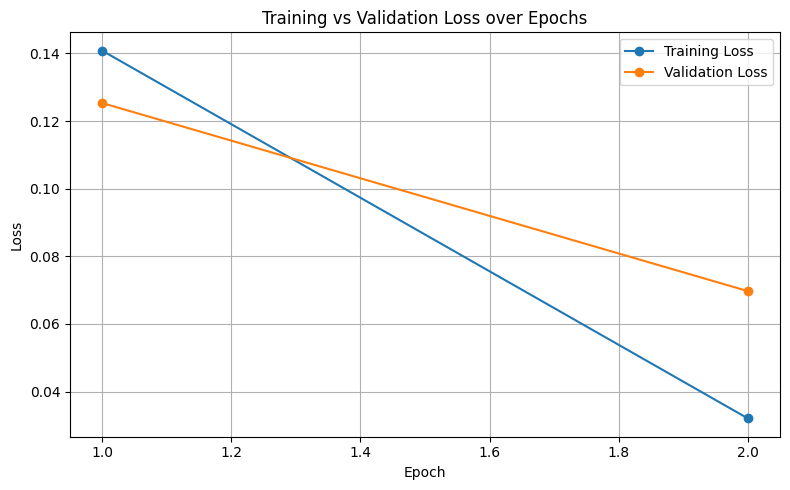

In [31]:
# ------------------------------------------------------------------------
# 9. Plot Training vs Validation Loss
#    Similar to your BART code, parse trainer.state.log_history
# ------------------------------------------------------------------------
def plotTrainerLossCurves(trainer):
    training_epochs, training_loss_vals = [], []
    validation_epochs, validation_loss_vals = [], []

    for record in trainer.state.log_history:
        if record.get("loss") is not None and record.get("epoch") is not None:
            training_loss_vals.append(record["loss"])
            training_epochs.append(record["epoch"])
        if record.get("eval_loss") is not None and record.get("epoch") is not None:
            validation_loss_vals.append(record["eval_loss"])
            validation_epochs.append(record["epoch"])

    plt.figure(figsize=(8, 5))
    plt.plot(training_epochs, training_loss_vals, label="Training Loss", marker='o')
    plt.plot(validation_epochs, validation_loss_vals, label="Validation Loss", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plotTrainerLossCurves(trainer)


In [36]:
def evaluateOnTestSet(trainer, tokenized_data, sample_size=500):
    subset = tokenized_data.select(range(sample_size))
    results = trainer.evaluate(eval_dataset=subset)
    print("Evaluation Results on Test Subset:", results)
    trainer.log_metrics("test", results)
    trainer.save_metrics("test", results)
    return results

testMetrics = evaluateOnTestSet(trainer, testData)

Evaluation Results on Test Subset: {'eval_loss': 0.12225746363401413, 'eval_accuracy': 98.4, 'eval_f1': 98.39, 'eval_runtime': 59.7787, 'eval_samples_per_second': 8.364, 'eval_steps_per_second': 8.364, 'epoch': 2.0}
***** test metrics *****
  epoch                   =        2.0
  eval_accuracy           =       98.4
  eval_f1                 =      98.39
  eval_loss               =     0.1223
  eval_runtime            = 0:00:59.77
  eval_samples_per_second =      8.364
  eval_steps_per_second   =      8.364


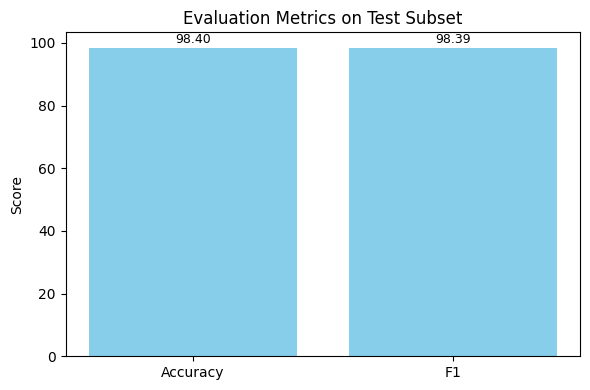

In [37]:
# Bar chart of final test metrics
def testMetricBarPlot(test_metrics):
    labels = ["Accuracy", "F1"]
    keys   = ["eval_accuracy", "eval_f1"]
    scores = [test_metrics[key] for key in keys]

    plt.figure(figsize=(6, 4))
    bars = plt.bar(labels, scores, color="skyblue")

    for bar, value in zip(bars, scores):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height+0.5, f"{value:.2f}",
                 ha='center', va='bottom', fontsize=9)

    plt.ylabel("Score")
    plt.title("Evaluation Metrics on Test Subset")
    plt.ylim(0, max(scores) + 5)
    plt.tight_layout()
    plt.show()

testMetricBarPlot(testMetrics)

In [38]:
torch.save(model.state_dict(), "DogCatClassification.pth")

In [39]:
from google.colab import files
files.download("DogCatClassification.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>